# Neural Network Forward Pass
---

## Import Libraries

In [1]:
import math
import operator

import torch
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
dataset = MNIST(root="../data/")

In [3]:
x, y = dataset.data.float(), dataset.targets
x_train, x_test = x[:50000], x[50000:]
y_train, y_test = y[:50000], y[50000:]

x_train.shape, x_test.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

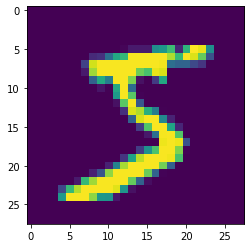

In [4]:
plt.imshow(x_train[0])

In [5]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

In [6]:
n, m = x_train.shape
c = (y_train.max() - y_train.min()).item()
n, m, c

(50000, 784, 9)

## Tests

In [7]:
def test(a, b, compare, compare_name=None):
    if compare_name is None:
        compare_name = compare.__name__
    assert compare(a, b),\
    f"{compare_name} check failed:\n{a}\n{b}"

def test_zero(x, tol=1e-3):
    test(x, tol, operator.le, f"Zero (less than tolerance: {tol})")
    
def test_equality(a, b):
    test(a, b, operator.eq, "Equality")

def test_approximately(a, b):
    allclose = partial(torch.allclose, atol=1e-5, rtol=1e-03)
    if not isinstance(a, torch.Tensor) or not isinstance(b, torch.Tensor):
        a = torch.tensor(a)
        b = torch.tensor(b)
    test(a, b, allclose, "Approximate Equality")

## Normalize Data

In [8]:
def normalize(x, mean, std): return (x-mean)/std

In [9]:
train_mean = x_train.mean()
train_std = x_train.std()

In [10]:
x_train = normalize(x_train, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std)

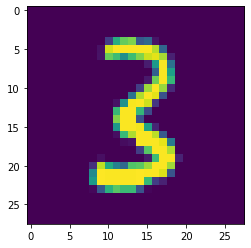

In [11]:
plt.imshow(x_test[0].view(28,28))

# Why is it difficult to train feedforward neural networks?

Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010)

## Problem: Exploding Activations

**Initializing linear layers**

In [12]:
nh1 = m//2
w1 = torch.randn(m, nh1)
b1 = torch.zeros(nh1)

nh2 = nh1//2 
w2 = torch.randn(nh1, nh2)
b2 = torch.zeros(nh2)

nh3 = nh2//2
w3 = torch.randn(nh2, nh3)
b3 = torch.zeros(nh3)

nh4 = nh3//2
w4 = torch.randn(nh3, nh4)
b4 = torch.zeros(nh4)

**Forward Pass**

In [13]:
x_train.mean(), x_train.std(), x_train.shape

(tensor(-7.6999e-06), tensor(1.), torch.Size([50000, 784]))

In [14]:
h1 = x_train@w1 + b1
h1.mean(), h1.std(), h1.shape

(tensor(0.2964), tensor(27.9827), torch.Size([50000, 392]))

In [15]:
h2 = h1@w2 + b2
h2.mean(), h2.std(), h2.shape

(tensor(2.9289), tensor(537.8209), torch.Size([50000, 196]))

In [16]:
h3 = h2@w3 + b3
h3.mean(), h3.std(), h3.shape

(tensor(112.1643), tensor(7692.3428), torch.Size([50000, 98]))

In [17]:
h4 = h3@w4 + b4
h4.mean(), h4.std(), h4.shape

(tensor(9801.2500), tensor(75005.3047), torch.Size([50000, 49]))

**We observe exploding activations as their standard deviations and mean increase drastically at every layer**

## Solution: Xavier Initialization

**Initializing linear layers with Xaiver Initialization**

In [18]:
nh1 = m//2
w1 = torch.randn(m, nh1) / math.sqrt(m)
b1 = torch.zeros(nh1)

nh2 = nh1//2 
w2 = torch.randn(nh1, nh2) / math.sqrt(nh1) 
b2 = torch.zeros(nh2)

nh3 = nh2//2
w3 = torch.randn(nh2, nh3) / math.sqrt(nh2)
b3 = torch.zeros(nh3)

nh4 = nh3//2
w4 = torch.randn(nh3, nh4) / math.sqrt(nh1)
b4 = torch.zeros(nh4)

**Forward Pass**

In [19]:
x_train.mean(), x_train.std(), x_train.shape

(tensor(-7.6999e-06), tensor(1.), torch.Size([50000, 784]))

In [20]:
h1 = x_train@w1 + b1
h1.mean(), h1.std(), h1.shape

(tensor(0.0436), tensor(1.0104), torch.Size([50000, 392]))

In [21]:
h2 = h1@w2 + b2
h2.mean(), h2.std(), h2.shape

(tensor(-0.0174), tensor(1.0042), torch.Size([50000, 196]))

In [22]:
h3 = h2@w3 + b3
h3.mean(), h3.std(), h3.shape

(tensor(-0.0114), tensor(1.0135), torch.Size([50000, 98]))

In [23]:
h4 = h3@w4 + b4
h4.mean(), h4.std(), h4.shape

(tensor(0.0132), tensor(0.5071), torch.Size([50000, 49]))

**The mean & std of activations remain fairly close to 0 and 1 respectively.**

## Problem: Vanishing Activations

**Linear layers with Relu activation**

In [24]:
def relu(x): return x.clamp_min(0.)

In [25]:
def linear_relu(x, weight, bias): return relu(x@weight + bias)

**Forward Pass**

In [26]:
x_train.mean(), x_train.std(), x_train.shape

(tensor(-7.6999e-06), tensor(1.), torch.Size([50000, 784]))

In [27]:
h1 = linear_relu(x_train, w1, b1)
h1.mean(), h1.std(), h1.shape

(tensor(0.4202), tensor(0.6041), torch.Size([50000, 392]))

In [28]:
h2 = linear_relu(h1, w2, b2)
h2.mean(), h2.std(), h2.shape

(tensor(0.3120), tensor(0.4489), torch.Size([50000, 196]))

In [29]:
h3 = linear_relu(h2, w3, b3)
h3.mean(), h3.std(), h3.shape

(tensor(0.2009), tensor(0.3210), torch.Size([50000, 98]))

In [30]:
h4 = linear_relu(h3, w4, b4)
h4.mean(), h4.std(), h4.shape

(tensor(0.0722), tensor(0.1102), torch.Size([50000, 49]))

**We observe the activations vanishing as their standard deviation reduces by half at every layer**

## Solution: Kaiming Initialization

**Initializing linear layers with Kaiming Initialization**

In [31]:
nh1 = m//2
w1 = torch.randn(m, nh1) * math.sqrt(2/m)
b1 = torch.zeros(nh1)

nh2 = nh1//2 
w2 = torch.randn(nh1, nh2) * math.sqrt(2/nh1) 
b2 = torch.zeros(nh2)

nh3 = nh2//2
w3 = torch.randn(nh2, nh3) * math.sqrt(2/nh2)
b3 = torch.zeros(nh3)

nh4 = nh3//2
w4 = torch.randn(nh3, nh4) * math.sqrt(2/nh1)
b4 = torch.zeros(nh4)

**Forward Pass**

In [32]:
x_train.mean(), x_train.std(), x_train.shape

(tensor(-7.6999e-06), tensor(1.), torch.Size([50000, 784]))

In [33]:
h1 = linear_relu(x_train, w1, b1)
h1.mean(), h1.std(), h1.shape

(tensor(0.5175), tensor(0.7877), torch.Size([50000, 392]))

In [34]:
h2 = linear_relu(h1, w2, b2)
h2.mean(), h2.std(), h2.shape

(tensor(0.5050), tensor(0.7644), torch.Size([50000, 196]))

In [35]:
h3 = linear_relu(h2, w3, b3)
h3.mean(), h3.std(), h3.shape

(tensor(0.5289), tensor(0.7422), torch.Size([50000, 98]))

In [36]:
h4 = linear_relu(h3, w4, b4)
h4.mean(), h4.std(), h4.shape

(tensor(0.2165), tensor(0.3361), torch.Size([50000, 49]))

**We observe the standard deviation of activations behaving much better with Kaiming initialization**

**However, the mean of the activations hover around 0.5.**

## Shifted Relu: Better Solution?

**Linear layers with shifted Relu activation**

In [37]:
def shift_relu(x): return x.clamp_min(0.) - 0.5

In [38]:
def linear_shift_relu(x, weight, bias): return shift_relu(x@weight + bias)

**Forward Pass**

In [39]:
x_train.mean(), x_train.std(), x_train.shape

(tensor(-7.6999e-06), tensor(1.), torch.Size([50000, 784]))

In [40]:
h1 = linear_shift_relu(x_train, w1, b1)
h1.mean(), h1.std(), h1.shape

(tensor(0.0175), tensor(0.7877), torch.Size([50000, 392]))

In [41]:
h2 = linear_shift_relu(h1, w2, b2)
h2.mean(), h2.std(), h2.shape

(tensor(-0.0701), tensor(0.6528), torch.Size([50000, 196]))

In [42]:
h3 = linear_shift_relu(h2, w3, b3)
h3.mean(), h3.std(), h3.shape

(tensor(-0.1287), tensor(0.5455), torch.Size([50000, 98]))

In [43]:
h4 = linear_shift_relu(h3, w4, b4)
h4.mean(), h4.std(), h4.shape

(tensor(-0.3418), tensor(0.2343), torch.Size([50000, 49]))

**The mean of activations remain close to zero at every layer**

# Feedforward Neural Network

## Linear Layer

In [44]:
class Linear():
    '''Affine layer with weight and bias initialized using Kaiming initialization'''
    def __init__(self, in_size, out_size):
        self.weight = torch.randn(in_size, out_size) * math.sqrt(2/in_size)
        self.bias = torch.zeros(out_size)
    
    def __repr__(self):
        return f"(Linear: in={self.weight.shape[0]} out={self.weight.shape[1]})"
        
    def forward(self, x):
        return x@self.weight + self.bias

## Activation Layer

In [45]:
class ReLU():
    '''Rectified Linear Unit Layer'''
    
    def __init__(self, shift=0.):
        self.shift = shift
    
    def __repr__(self):
        return f"(ReLU: shift={self.shift})"
    
    def forward(self, x):
        return x.clamp_min(0.) - self.shift

## Feedforward Network

In [46]:
class FeedForwardNN():
    '''Feedforward neural network'''
    
    def __init__(self, x_size, y_size, num_layers):
        downsize = (x_size-y_size)//num_layers
        in_size = x_size
        out_size = x_size-downsize
        self.layers = [Linear(in_size, out_size), ReLU()]
        for i in range(num_layers-2):
            in_size = out_size 
            out_size = in_size - downsize
            self.layers.append(Linear(in_size, out_size))
            self.layers.append(ReLU())
        in_size = out_size
        out_size = y_size
        self.layers.append(Linear(in_size, out_size))
    
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x

In [47]:
model = FeedForwardNN(784, 10, 5)

In [48]:
model.layers

[(Linear: in=784 out=630),
 (ReLU: shift=0.0),
 (Linear: in=630 out=476),
 (ReLU: shift=0.0),
 (Linear: in=476 out=322),
 (ReLU: shift=0.0),
 (Linear: in=322 out=168),
 (ReLU: shift=0.0),
 (Linear: in=168 out=10)]

In [49]:
y_pred = model.forward(x_train)

In [50]:
y_pred.shape, y_train.shape

(torch.Size([50000, 10]), torch.Size([50000]))

## Evaluation

### Mean Squared Error

In [51]:
def mse(y_pred, y_true): return (y_pred - y_true).pow(2).mean()

In [52]:
model = FeedForwardNN(784, 1, 5)
y_pred = model.forward(x_train)

In [53]:
mse(y_pred.squeeze(-1), y_train.float())

tensor(34.7165)

### Binary Cross Entropy Error

In [54]:
def cross_entropy_scalar(y_hat, y):
    if y==1:
        return -y_hat.log()
    elif y==0.:
        return -(1-y_hat).log()

In [55]:
def cross_entropy(y_hat, y):
    return -(y*y_hat.log() + (1-y)*(1-y_hat).log())

In [56]:
model = FeedForwardNN(784, 10, 5)
y_pred = model.forward(x_train)

In [57]:
y_one_hot = torch.nn.functional.one_hot(y_train)
cross_entropy(y_pred, y_one_hot.float())

tensor([[   nan,    nan, 0.1064,  ...,    nan,    nan, 2.2289],
        [1.9161,    nan,    nan,  ...,    nan,    nan, 2.1351],
        [   nan,    nan,    nan,  ...,    nan, 0.2495, 0.8286],
        ...,
        [   nan,    nan, 0.2143,  ...,    nan, 0.2518,    nan],
        [   nan, 1.5226,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ..., 0.1055,    nan,    nan]])